# Big Model 2 for all routes.

In [31]:
from dbanalysis import stop_tools
import pandas as pd
class BRModel():
    """
    Big route model class
    uses the distance of a stop from first stop on a route to compute predictions lalalala
    MAPE and r2 scores are not as good as they were in the notebook
    (we achieved 0.57 r2, and 7% MAPE on the time to complete the route)
    Should look into this.
    """
    def __init__ (self, route,variation,verbose=True,src='build',rgr='RandomForest',\
                mode='validate',features = ['base_time_dep','weekend','distance','vappr'],use_dummies=True):
        
        import json
        self.regr_type = rgr
        self.verbose = verbose
        self.route = route
        self.use_dummies = use_dummies
        self.variation = variation
        self.routes = json.loads(open('/home/student/dbanalysis/dbanalysis/resources/trimmed_routes.json').read())
        self.features = features
        self.route_array = self.routes[route][variation][1:]
        del(self.routes)
        if src == 'build':
            if not self.can_be_modelled():
                print('fuck')
                raise ValueError ('Missing data for modelling this route')

            self.gather_data()
            self.preprocess()
            if rgr == 'RandomForest':
                from sklearn.ensemble import RandomForestRegressor as rf
                self.rgr = rf()
            elif rgr == 'Linear':
                from sklearn.linear_model import LinearRegression as lr
                self.rgr = lr(fit_intercept=True)
            elif rgr == 'Neural':
                from sklearn.neural_network import MLPRegressor as mlpr
                self.rgr = mlpr(hidden_layer_sizes=(80,80,80,80))
                #self.features = [f for f in self.features \
                #                if f[0:4]!='hour']
                
 

    def gather_data(self):
        if self.verbose:
            print('gathering data...')
        from dbanalysis import stop_tools
        arr = self.route_array
        import os
        to_concat = []
        for i in range(len(arr)-1):
            
            data = stop_tools.get_stop_link(arr[i],arr[i+1])
            to_concat.append(data)
            del(data)
        self.data = pd.concat(to_concat,axis=0)
        del to_concat
        

    def preprocess(self):
        if self.verbose:
            print('Preprocessing data')
        self.select_routes()
        self.clean_1()
        self.add_distances()
        self.add_base_departure_time()
        self.add_time_info()
        
        self.merge_weather()
        if self.use_dummies:
            self.add_dummies()
            self.features += self.dummy_features
        self.data = self.data[self.data['distance']>0]
    def select_routes(self):
        if self.verbose:
            print('parsing routeids')
        routeids = self.data['routeid'].unique()
        valid_routeids = [r for r in routeids if r.split('_')[0] == self.route]
        self.data = self.data[self.data['routeid'].isin(valid_routeids)]
    def clean_1(self):
        if self.verbose:
            print('dropping null values')
        self.data = self.data.dropna()
        
    def add_distances(self):
        if self.verbose:
            print('adding distances')
        s_getter =stop_tools.stop_getter()
        total_distance = 0
        r = self.route_array
        route_distances = {r[0]:0}
        
        for i in range(0, len(r)-1):
            distance = s_getter.get_stop_distance(str(r[i]),str(r[i+1]))
                
            total_distance += distance
            route_distances[r[i+1]]=total_distance
        self.data['distance']=self.data['stopA'].apply(lambda x: route_distances[x])
        del(s_getter)
    def add_base_departure_time(self):
        if self.verbose:
            print('adding base departure times')
       
        keys= self.data[self.data['stopA']==self.route_array[0]]
        keys['base_time_dep']=keys['actualtime_arr_from']
        keys2=keys[['tripid','dayofservice','base_time_dep']]
        self.data = pd.merge(self.data,keys2,on=['dayofservice','tripid'])
        
        self.data['traveltime']=self.data['actualtime_arr_from']-self.data['base_time_dep']        
        del(keys)
        del(keys2)
    
    def add_time_info(self):
        if self.verbose:
            print('adding time information')
        time_format = "%d-%b-%y %H:%M:%S"
        self.data['dt']=pd.to_datetime(self.data['dayofservice'],format=time_format)
        self.data['day']=self.data['dt'].dt.dayofweek
        self.data['month']=self.data['dt'].dt.month
        self.data['hour'] = self.data['base_time_dep']//3600
        self.data['weekend']=self.data['day']>4
        self.data['year']=self.data['dt'].dt.year
        self.data['date'] = self.data['dt'].dt.date
    def merge_weather(self,weather=None):
        if self.verbose:
            print('merging weather')
        if weather == None:
          
            weather = pd.read_csv('/home/student/dbanalysis/dbanalysis/resources/cleanweather.csv').dropna()
        weather['dt']=pd.to_datetime(weather['date'])
        weather['hour']=weather['dt'].dt.hour
        weather['date']=weather['dt'].dt.date
        
        self.data = pd.merge(self.data,weather,on=['date','hour'])
        del(weather)

    def add_dummies(self):
        if self.verbose:
            print('Making dummy features')
        self.data = pd.get_dummies(self.data,columns=['hour','day','month'])
        self.dummy_features = [col for col in self.data.columns\
                               if col[0:4]=='hour' or col[0:5]=='month' or (col[0:3]=='day' and \
                                                                           col!='dayofservice')]


    def can_be_modelled(self):
        if self.verbose:
            print('Checking for data files')
        import os
        base_dir = '/data/stops/'
        arr = self.route_array
        for i in range(len(arr)-1):
            
            if os.path.exists(base_dir+str(arr[i])+'/'+str(arr[i+1])+'.csv'):
                pass
            else:
                print('broken')
                input()
                return False
        return True


In [21]:
r=BRModel('15',1,rgr='Neural')

Checking for data files
gathering data...
Preprocessing data
parsing routeids
dropping null values
adding distances
adding base departure times


/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


adding time information
merging weather
Making dummy features


In [22]:
from sklearn.preprocessing import MinMaxScaler as mms
import numpy as np
train = r.data[r.data['year']==2016]
train_X = train[r.features]
train_Y = np.array([i for i in train['traveltime']]).reshape(-1,1)
transformer1 = mms().fit(train_X)
transformer2=mms().fit(train_Y)
train_X = transformer1.transform(train_X)
train_Y = transformer2.transform(train_Y)

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
model = r.rgr.fit(train_X,train_Y)

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
test = r.data[r.data['year']==2016]
real_traveltimes = test['traveltime']
test_X = test[r.features]
test_Y = np.array([i for i in test['traveltime']]).reshape(-1,1)
test_X = transformer1.transform(test_X)
test_Y = transformer2.transform(test_Y)
preds = model.predict(test_X)
real_preds = transformer2.inverse_transform(preds.reshape(-1,1)).reshape(-1,1)

In [26]:
from sklearn import metrics

In [29]:
metrics.mean_absolute_error(real_preds,real_traveltimes)

221.3879546582816

In [58]:
real_preds = transformer2.inverse_transform(preds.reshape(-1,1))

/home/student/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/student/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


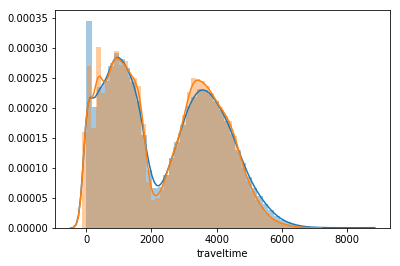

In [49]:
import seaborn as sns
sns.distplot(real_traveltimes)
sns.distplot(real_preds)



In [51]:
metrics.mean_absolute_error(real_traveltimes,real_preds)

221.3879546582816

In [59]:
real_preds = [i[0] for i in real_preds]

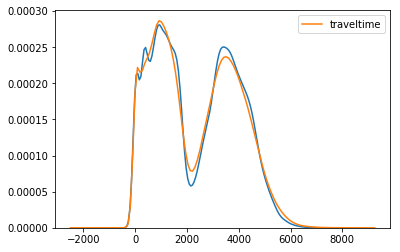

In [60]:
sns.kdeplot(real_preds)
sns.kdeplot(real_traveltimes)

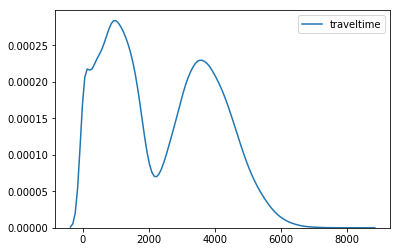

In [50]:
sns.kdeplot(real_traveltimes)

In [62]:
test.sample()

,index,dayofservice,tripid,plannedtime_arr_from,plannedtime_dep_from,actualtime_arr_from,actualtime_dep_from,plannedtime_arr_to,actualtime_arr_to,routeid,...,day_3,day_4,day_5,day_6,month_1,month_2,month_3,month_4,month_5,month_6
918833,442621,26-APR-16 00:00:00,3019775,82472,82472,82497,82528,82581,82587,15_16,...,0,0,0,0,0,0,0,1,0,0


In [63]:
a=test.sample()
model.predict(test[r.features])

array([-1747.50374847, -1747.48816783, -1747.46955524, ...,
       -1798.51867752, -1798.49389175, -1798.44281792])

In [64]:
model.predict(a[r.features])

array([-1251.99886861])

In [74]:
distances = []
preds = []
current_distance = 0
while current_distance < 25:
    a['distance']=current_distance
    b = transformer1.transform(a[r.features])
    preds.append(model.predict(b)[0])
    distances.append(current_distance)
    current_distance += 0.05

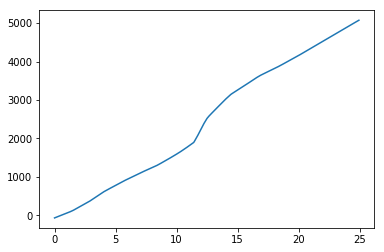

In [75]:
real_preds = transformer2.inverse_transform([[i] for i in preds])
from matplotlib import pyplot as plt
plt.plot(distances,real_preds)